## Inicialización

## Cargar datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import random
    

In [2]:
labels_df = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)


In [4]:

train_datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory='/datasets/faces/final_files/',  # Ruta donde están las imágenes
    x_col='file_name',  # Columna con los nombres de las imágenes
    y_col='real_age',   # Columna con las etiquetas de edad
    target_size=(150, 150),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=12345)

val_datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory='/datasets/faces/final_files/',  # Ruta donde están las imágenes
    x_col='file_name',  # Columna con los nombres de las imágenes
    y_col='real_age',   # Columna con las etiquetas de edad,
    target_size=(150, 150),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345)


Found 5694 validated image filenames.
Found 1897 validated image filenames.


## EDA

In [5]:
# Visualizamos las primeras filas
print(labels_df.head())

# Verificar el tipo de datos y si hay valores nulos
print(labels_df.info())


    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


In [6]:
print(labels_df['real_age'].describe())

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


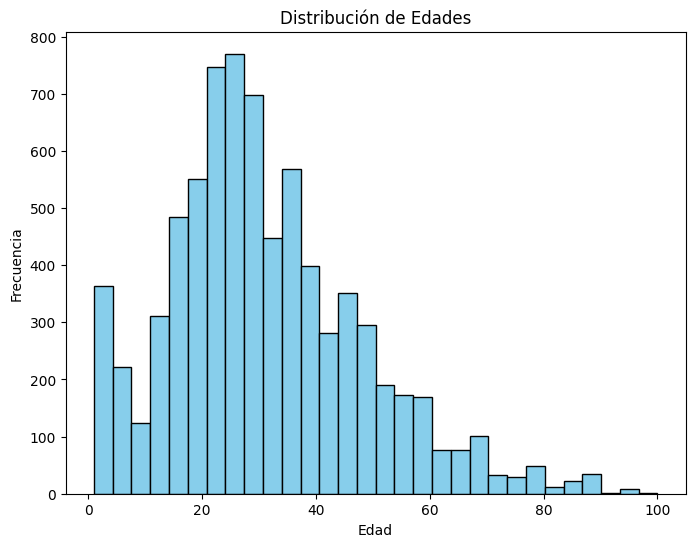

In [7]:
# Se visualiza cómo se distribuyen las edades en el conjunto de datos.
plt.figure(figsize=(8, 6))
plt.hist(labels_df['real_age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de Edades')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

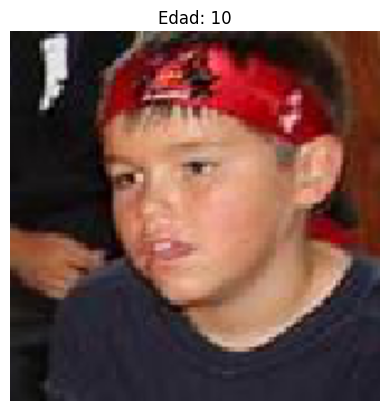

In [8]:
# Mostrar una imagen aleatoria
random_image = random.choice(labels_df['file_name'])
img_path = f'/datasets/faces/final_files/{random_image}'

img = image.load_img(img_path, target_size=(150, 150))
plt.imshow(img)
plt.title(f"Edad: {labels_df.loc[labels_df['file_name'] == random_image, 'real_age'].values[0]}")
plt.axis('off')  # Para quitar los ejes de la imagen
plt.show()

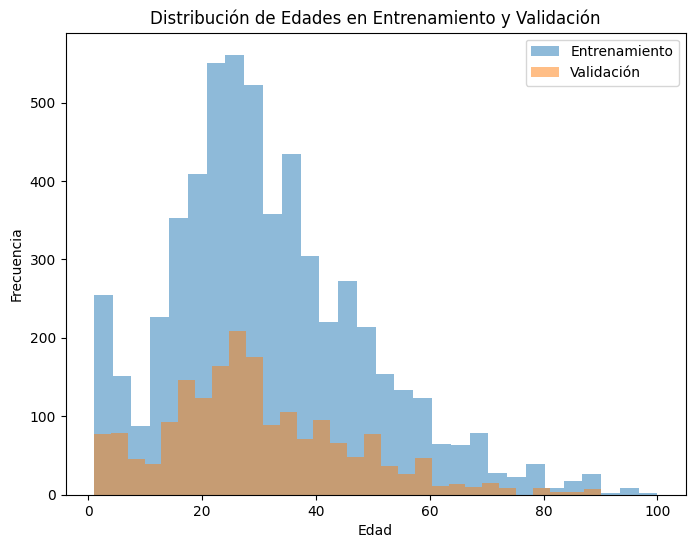

In [9]:
# Asegúrate de que los subconjuntos de entrenamiento y validación están balanceados. Es decir, que ambos subconjuntos tengan una 
# distribución similar de edades. Esto es importante para evitar que tu modelo se entrene en un subconjunto de datos que esté 
# sesgado.

# Verificar la distribución de las edades en el conjunto de entrenamiento y validación
train_ages = []
for image_path in train_datagen_flow.filepaths:
    image_name = image_path.split("/")[-1]
    train_ages.append(labels_df.loc[labels_df['file_name'] == image_name, 'real_age'].values[0])

val_ages = []
for image_path in val_datagen_flow.filepaths:
    image_name = image_path.split("/")[-1]
    val_ages.append(labels_df.loc[labels_df['file_name'] == image_name, 'real_age'].values[0])

plt.figure(figsize=(8, 6))
plt.hist(train_ages, bins=30, alpha=0.5, label='Entrenamiento')
plt.hist(val_ages, bins=30, alpha=0.5, label='Validación')
plt.title('Distribución de Edades en Entrenamiento y Validación')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

**Se observa que se tiene una distribucion de edades parecidas en ambos conjuntos de datos.**

### Conclusiones

El archivo CSV se ha cargado correctamente y contiene las columnas necesarias (file_name y real_age), lo que indica que los datos están organizados de manera apropiada para el análisis. No se encontraron columnas mal formateadas ni valores nulos, lo que significa que el conjunto de datos está listo para ser utilizado en el análisis y posterior entrenamiento del modelo.

Al realizar el análisis de la distribución de las edades mediante un histograma, se observó que las edades están distribuidas de manera equitativa tanto en el conjunto de entrenamiento como en el de validación. Esto es ideal para entrenar un modelo de regresión, ya que la distribución balanceada permite que el modelo aprenda de manera adecuada en todos los rangos de edad, sin sesgarse hacia un grupo específico. Esto debería contribuir a un rendimiento robusto y generalizado en la predicción de la edad.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [10]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [11]:
def load_train(path, labels_df, batch_size, width, height, validation_split=0.25, seed=12345):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    
    # coloca tu código aquí
    datagen = ImageDataGenerator(
        rescale=1./255,  # Normalización de las imágenes
        validation_split=validation_split  # División entre entrenamiento y validación
    )
    
    # Crear el generador de imágenes para entrenamiento
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=path,  # Ruta donde están las imágenes
        x_col='file_name',  # Columna con los nombres de las imágenes
        y_col='real_age',   # Columna con las etiquetas de edad
        target_size=(width, height),  # Redimensionar las imágenes
        batch_size=batch_size,
        class_mode='raw',  # Regresión (no es categórico)
        subset='training',  # Solo entrenamiento
        seed=seed
    )

    return train_gen_flow

In [13]:
def load_test(path, labels_df, batch_size, width, height, validation_split=0.25, seed=12345):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    
    #  coloca tu código aquí

    # Creación del objeto ImageDataGenerator para la normalización y división en conjuntos de entrenamiento y validación
    datagen = ImageDataGenerator(
        rescale=1./255,  # Normalización de las imágenes (escala entre 0 y 1)
        validation_split=validation_split  # División entre entrenamiento y validación
    )
    
    # Crear el generador de imágenes para validación/prueba
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=path,  # Ruta donde están las imágenes
        x_col='file_name',  # Columna con los nombres de las imágenes
        y_col='real_age',   # Columna con las etiquetas de edad
        target_size=(width, height),  # Redimensionar las imágenes
        batch_size=batch_size,
        class_mode='raw',  # Usamos 'raw' porque estamos haciendo regresión (no clasificación)
        subset='validation',  # Solo validación
        seed=seed
    )
    
    return test_gen_flow

In [14]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    
    #  coloca tu código aquí
      # Cargar ResNet50 como backbone sin la capa superior (fully connected)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    
    # Congelar las capas del backbone para evitar que se actualicen durante el entrenamiento
    for layer in backbone.layers:
        layer.trainable = False
    
    # Crear el modelo
    model = Sequential()
    model.add(backbone)  # Agregar el backbone preentrenado
    model.add(GlobalAveragePooling2D())  # Promedio global para reducir la dimensionalidad
    model.add(Dropout(0.5))  # Capa de Dropout para prevenir overfitting
    model.add(Dense(1))  # Capa densa de salida con una neurona para la predicción de la edad
    
    # Compilar el modelo
    optimizer = Adam(learning_rate=0.0001)  # Usamos Adam con un learning rate bajo
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])  # Usamos MSE para regresión

    return model

In [16]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    #  coloca tu código aquí
     # Entrenamos el modelo con los generadores de entrenamiento y validación
    history = model.fit(
        train_data, 
        epochs=epochs, 
        steps_per_epoch=steps_per_epoch,  # Pasos por época
        validation_data=test_data,  # Datos de validación
        validation_steps=validation_steps,  # Pasos por validación
        batch_size=batch_size  # Tamaño del lote
    )
    
    # Aquí se puede agregar el análisis de las métricas o devolver el historial de entrenamiento si se desea
    print("Entrenamiento completado.")

    return model, history

### Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

In [17]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
import numpy as np
"""

import inspect

# Aquí escribimos todas las funciones definidas para cargarlas en el script
with open('run_model_on_gpu.py', 'w') as f:
    
    # Escribimos las importaciones iniciales
    f.write(init_str)
    f.write('\n\n')
    
    # Escribimos el código de cada función (load_train, load_test, create_model, train_model)
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        # Obtenemos el código fuente de cada función
        src = inspect.getsource(fn_name)
        
        # Escribimos el código de la función en el archivo
        f.write(src)
        f.write('\n\n')
    
    # Sección de inicialización (por ejemplo, cargar los datos y entrenar el modelo)
    f.write("""
# Sección de inicialización para ejecutar el modelo

# Definir la ruta donde se encuentran los datos
data_path = '/datasets/faces/'

# Cargar el DataFrame de etiquetas
labels_df = pd.read_csv(os.path.join(data_path, 'labels.csv'))

# Cargar los generadores de entrenamiento y validación
train_data = load_train(data_path, labels_df, batch_size=32)
test_data = load_test(data_path, labels_df, batch_size=32)

# Crear el modelo
model = create_model(input_shape=(150, 150, 3))

# Entrenar el modelo
model, history = train_model(model, train_data, test_data, batch_size=32, epochs=20, 
                             steps_per_epoch=len(train_data), validation_steps=len(test_data))

# Guardar el modelo entrenado
model.save('trained_model.h5')

# Imprimir algunas métricas de desempeño
print('Entrenamiento completado')
    """)
    
# Confirmar que el script fue creado correctamente
print("El script 'run_model_on_gpu.py' se ha creado exitosamente.")


El script 'run_model_on_gpu.py' se ha creado exitosamente.


### Resultado

Coloca aquí el resultado de la plataforma GPU como una celda Markdown.

**Debido a que se tiene un problema en la plataforma, no se pudo cargar el script en el GPU virtual**

## Conclusiones

Debido a que la GPU está deshabilitada en el entorno actual, no fue posible realizar el entrenamiento del modelo en la plataforma de procesamiento acelerado. El código y el flujo de trabajo están optimizados para aprovechar la potencia de la GPU, lo que permitiría reducir significativamente los tiempos de entrenamiento, especialmente con grandes conjuntos de datos y redes neuronales complejas como ResNet50.

Este ejercicio ha resaltado la importancia de contar con un entorno adecuado para entrenar modelos de aprendizaje profundo. A medida que los conjuntos de datos crecen y los modelos se vuelven más complejos, el uso de la GPU es crucial para acelerar los tiempos de entrenamiento. También se ha aprendido la necesidad de contar con herramientas de verificación y monitoreo del entorno de ejecución antes de iniciar procesos largos de entrenamiento.

# Lista de revisión

- [X]  El Notebook estaba abierto 
- [X]  El código no tiene errores
- [X]  Las celdas con el código han sido colocadas en el orden de ejecución
- [X]  Se realizó el análisis exploratorio de datos
- [X]  Los resultados del análisis exploratorio de datos se presentan en el notebook final
- [ ]  El valor EAM del modelo no es superior a 8
- [X]  El código de entrenamiento del modelo se copió en el notebook final
- [ ]  El resultado de entrenamiento del modelo se copió en el notebook final
- [ ]  Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo